# PyTorch Tutorial
Author: Clark Miyamoto (NYU)

Today we'll implement a basic neural network, and apply it to a regression problem. In the exercise, you'll train an image classifier!

# Import & Verify `PyTorch` is working

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

print(torch.__version__)

2.5.1


# Tensors

Let's start with something you should know, `numpy`. This is a scientific computing library which allows for each manipulation of vectors & matricies. `PyTorch` has a similar data structure called a `Tensor`.

In [3]:
# Create some vectors
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])

# Create a matrix
M = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

# Create a tensor with specific dimensions
batch_size = 10
dim = 3
T = torch.randn(size=(batch_size, dim, dim))
S = torch.rand(size=(batch_size, dim, dim))
# `randn` generates a RANDom values drawn from a Normal distribution.
print(T.shape)


torch.Size([10, 3, 3])


Q1) What is the default datatype for `Tensors` in `PyTorch`? Note it depends on how you initalize the tensor.

In [4]:
# Addition / muliplication work element-wise, just like numpy
print(a + b)
print(a * b)

# `@` operator does matrix multiplication
print(a @ b)
print(M @ a)

tensor([5, 7, 9])
tensor([ 4, 10, 18])
tensor(32)
tensor([14, 32, 50])


In [5]:
# There's also einstein summation
# Example: a @ b
print(torch.einsum('i,i->', a, b))
print(a @ b)

# Example: M @ a
print(torch.einsum('ij,j->i', M, a))
print( M @ a)

# Example: Tr(M)
print(torch.einsum('ii->', M))
print(torch.trace(M))

# We can also do more complicated things, like batch matrix multiplication
# So instead of running
# > for i in range(batch_size):
# >    C[i] = T[i] @ S[i]
# We can do it all at once with einsum
C = torch.einsum('bij,bjk->bik', T, S)
print(C.shape)

tensor(32)
tensor(32)
tensor([14, 32, 50])
tensor([14, 32, 50])
tensor(15)
tensor(15)
torch.Size([10, 3, 3])


# Importing Custom Data 
You'll be working with custom datasets, so it'll be good to go over how to import data. Let's imagine we want to fit a noisy sine curve.


Text(0.5, 1.0, 'Synthetic Data')

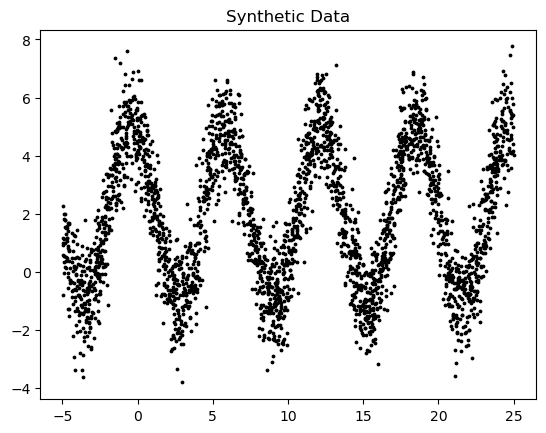

In [6]:
num_data = 3000
x = torch.rand(num_data) * 30 - 5  # Uniformly distributed between -5 and 5
y = 3 * torch.sin(x + 2) + torch.randn(num_data) + 2

plt.scatter(x.numpy(), y.numpy(), s=3, color='black')
plt.title('Synthetic Data')

In PyTorch, to make a custom dataset, you construct a class which inherits `torch.Dataset`

```python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    """Custom data."""
    
    def __init__(self, args):
        self.x: Tensor = ... # (batch, dim_features)
        self.y: Tensor = ... # (batch, dim_labels)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
```

In [11]:
class SineDataset(Dataset):

    def __init__(self, num_data):
        self.x = torch.rand(num_data) * 30 - 5  # Uniformly distributed between -5 and 5
        self.y = 3 * torch.sin(self.x + 2) + torch.randn(num_data) + 2
        
        self.x = self.x.unsqueeze(1)  # Make it a column vector
        self.y = self.y.unsqueeze(1)  # Make it a column vector
        print(self.x.shape, self.y.shape)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = SineDataset(num_data=3000)
dataset_val = SineDataset(num_data=500)

torch.Size([3000, 1]) torch.Size([3000, 1])
torch.Size([500, 1]) torch.Size([500, 1])


This packages the data. PyTorch then uses the `Dataloader` class to randomly sample data in the training set. You have to define the `batch_size`, which will be introduced in optimization...

In [13]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

# Model Architecture

In class, we discussed a simple multilayer perceptron. Recall it was mathematically defined as a composition of affine trasformations & non-linear activation functions
$$
\begin{align}
\text{Linear}^{(\ell)}(x) & = W^{(\ell)} x + b^{(\ell)}, b^{(0)}\\
f_\theta(x) & = \text{Linear}^{(L)} \circ \sigma \circ \text{Linear}^{(L-1)} \circ \sigma \circ ... \circ x
\end{align}
$$
where the model parameter $\theta = \{W^{(\ell)}, b^{(\ell)}\}_{\ell=0}^L$ and $\sigma(\cdot)$ is a non-linear activation function. Note $\sigma$ is appplied element-wise.

To build models, these are done by defining child classes which inherit from the `nn.Module` class. Childs must implement the `__init__` and `forward` methods.
```python
from torch import nn
class ModelName(nn.Module):
    def __init__(self, args):
        super(ModelName, self).__init__()
        # Define intermediate layers of the model
        ...
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Hook up the layers to construct the forward pass
        return ... # Output goes here

model = ModelName(...)
model(x) # Calls `forward`. Acts like f_\theta(x).
```



Below is a skeleton of how to define a simple MLP with one hidden layer.

In [74]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.LeakyReLU()

    
    def forward(self, x):
        out = self.input(x)
        out = self.activation(out)
        out = self.hidden(out)
        out = self.activation(out)
        out = self.hidden2(out)
        out = self.activation(out)
        out = self.output(out)
        return out

In [75]:
model = MLP(input_size=1, hidden_size=128, output_size=1)
model(dataset_train[0][0])  # Reshape image to (1, 784)

tensor([0.2272], grad_fn=<ViewBackward0>)

# Training

## Optimization Loop
Let's attempt training the network. Recall the loss function looks like
$$
\begin{align}
\mathcal L(\theta) & = \sum_{(x,y) \in \mathcal D_{tr}} \ell(f_\theta(x), y) + r(\theta)\\
\end{align}
$$

Now how do we implement $\arg \min_\theta \mathcal L(\theta)$? One idea is to recall 3Blue1Brown, "the gradient points in the direciton of steepest ascent". So if you want to minimize, take the negative of the graident!

A simple (but dumb!) idea is to just traverse in the direction of steepest descent all the time
$$
\theta_{t+1} \leftarrow \theta_t + h_t \, \nabla_\theta \mathcal L(\theta)
$$
where $h_t$ is the stepsize. This is called **natural/full batch gradient descent**.

Why might this be a dumb idea? The loss funciton is multimodal, in the sense there are multiple local minima, this can easily get trapped in a local minima and you'll be stuck there forever...

Well what if you got random subset of data $S_{batch} \subset \mathcal D_{tr}$, and per optimization step you sampled another subset? Your loss landscape would change with every iteration, preventing you from being trapped / overfitting. Another benefit is that you can't hold $\mathcal D_{tr}$ in memory, so your life got a little more simple.

$$
\mathcal L(\theta) = \sum_{(x,y) \in S_{batch}} \ell(f_\theta(x), y) + r(\theta)
$$


## Loss Function
There are many choices of loss functions. We just hope that when it is globally minimze, then $f(x) = y$ for all $x,y \in \mathcal D_{tr}$. For simplicity, let's choose **mean squared error (MSE)**, that is $\ell(x,y) = (x - y)^2$, without regularization $r = 0$.

$$
\begin{align}
= \sum_{(x,y) \in \text{batch}} (f_\theta(x)- y)^2\\
\end{align}
$$




In [ ]:
def run_optimization(num_epochs: int, optimizer, criterion):
    model.train() # Enable dropout, batch norm training mode, etc.
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data) # Forward pass
            loss = criterion(output, target) # Compute loss
            
            optimizer.zero_grad()   # Zero gradients from previous step
            loss.backward()         # Backpropagation
            optimizer.step()        # Update weights
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [81]:
# Optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss Funciton
criterion = nn.MSELoss()

run_optimization(num_epochs=100, optimizer=optimizer, criterion=criterion)

Epoch 1/100, Loss: 1.1630
Epoch 2/100, Loss: 1.1412
Epoch 3/100, Loss: 1.1723
Epoch 4/100, Loss: 1.0969
Epoch 5/100, Loss: 1.1796
Epoch 6/100, Loss: 1.1148
Epoch 7/100, Loss: 1.1878
Epoch 8/100, Loss: 1.1796
Epoch 9/100, Loss: 1.1415
Epoch 10/100, Loss: 1.1284
Epoch 11/100, Loss: 1.2081
Epoch 12/100, Loss: 1.1567
Epoch 13/100, Loss: 1.1446
Epoch 14/100, Loss: 1.1077
Epoch 15/100, Loss: 1.1285
Epoch 16/100, Loss: 1.1740
Epoch 17/100, Loss: 1.1360
Epoch 18/100, Loss: 1.1276
Epoch 19/100, Loss: 1.1038
Epoch 20/100, Loss: 1.1429
Epoch 21/100, Loss: 1.1442
Epoch 22/100, Loss: 1.0833
Epoch 23/100, Loss: 1.1124
Epoch 24/100, Loss: 1.1859
Epoch 25/100, Loss: 1.1199
Epoch 26/100, Loss: 1.1161
Epoch 27/100, Loss: 1.2709
Epoch 28/100, Loss: 1.1703
Epoch 29/100, Loss: 1.1415
Epoch 30/100, Loss: 1.2085
Epoch 31/100, Loss: 1.1596
Epoch 32/100, Loss: 1.1214
Epoch 33/100, Loss: 1.0812
Epoch 34/100, Loss: 1.1271
Epoch 35/100, Loss: 1.2139
Epoch 36/100, Loss: 1.2277
Epoch 37/100, Loss: 1.1678
Epoch 38/1

KeyboardInterrupt: 

# Inference / Validation

Let's validate our model's performance by running it on the validation data

In [ ]:
model.eval()

y_pred_test = model(dataset_val.x)
sorted_indices = torch.argsort(dataset_val.x.squeeze())
x_sorted = dataset_val.x[sorted_indices]
y_pred_sorted = y_pred_test[sorted_indices]

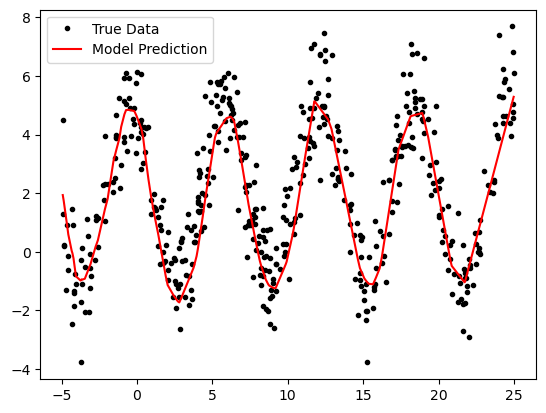

In [90]:
plt.plot(dataset_val.x.numpy(), dataset_val.y.numpy(), 'o', color='black', label='True Data', markersize=3)
plt.plot(x_sorted.detach().numpy(), y_pred_sorted.detach().numpy(), '-', color='red', label='Model Prediction')
plt.legend()

Wow it works quite well. Perhaps to be triple sure, let's try it outside the set

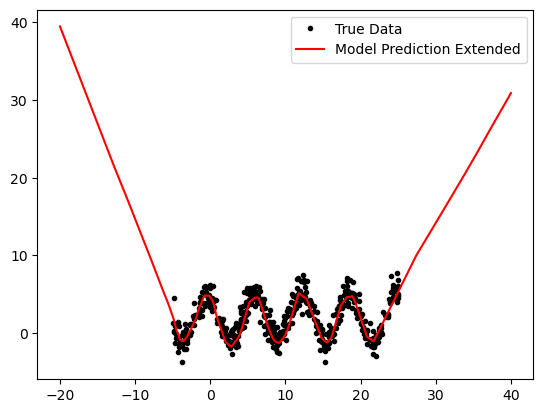

In [91]:
xs = torch.linspace(-20,40,1000)
ys = model(xs.unsqueeze(1))

plt.plot(dataset_val.x.numpy(), dataset_val.y.numpy(), 'o', color='black', label='True Data', markersize=3)
plt.plot(xs.numpy(), ys.detach().numpy(), '-', color='red', label='Model Prediction Extended')
plt.legend()
plt.show()

# Logging
When doing more complicated training, it's nice to diagnose in something more fancy than print statements. I recommend https://wandb.ai/site/.